# Naver 영화 리뷰 감성 분석 모델 제작하기

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. 결측값, 불용값 제거. 단어 토큰화. 사전 생성(index_to_word)
        -2. 패딩 값 설정, 문장 길이 정형화 
        -3. 검증데이터 분리
        
        
    2-3. 모델 학습 및 평가 
        -1. RNN
        -2. CNN 1-D
        -3. CNN global maxpooling
        
    2-4. Pre-trained Embedding data (Ko)
        -1. 우리 단어사전 분석
        -2. pre-trained 임베딩 써보기

### 3. POTG
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  


## 1. Ready

### 1-1. 오늘의 Exp와 Rubric

오늘 진행한 Exploration은 네이버 영화 리뷰 데이터를 바탕으로  
리뷰 감성 분석 NLP 모델을 만드는 것이다.

진행 중점사항은 다음과 같다.

- 1. RNN , 1-D CNN(Conv1D) ,1-D CNN(globalmaxpooling) 총 세 모델을 사용해 비교하기
- 2. 한국어 Word2Vec 모델로 변환하여 성능 비교하기

루브릭은 다음과 같다.

|평가문항|상세기준|
|-|-|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

### 1-2. 사용하는 라이브러리




In [1]:
import os

import numpy as np
import pandas as pd

import re

import tensorflow as tf
from tensorflow.keras.initializers import Constant

from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from konlpy.tag import Mecab
from collections import Counter

import matplotlib.pyplot as plt

#gensim==3.8.1

- os
- numpy  
- pandas   
- tensorflow  
- Constant  
- gensim  
- Mecab 형태소 분석기
- Counter

## 2. GAME

### 2-1. DATA 불러오기

우리가 사용할 데이터는 네이버 영화 평점사이트에서 스크랩해온 고객 리뷰 말뭉치이다.

데이터는 전 네이버 머신러닝 엔지니어 Lucy Park 이사님께서  
Git을 통해 무료 배포하고 있다.

[Naver Sentimental Movie corpus 무료 다운로드::](https://github.com/e9t/nsmc)

우리는 그 배포 자료중 이미 test와 train으로 나누어 주신 데이터를 쓴다.

<img src="./img/data.PNG"></img>

Train 데이터는 150K (15만) reviews가, 
test 데이터는 50K reviews 가 존재하고, 

각 데이터 행마다 Id, Document, Label 열의 정보를 가지고 있다.

* ID : 고객 아이디
* Document : 실제로 쓴 한국어 리뷰
* Label : 극성 ( 0- 부정 1- 긍정 )

<img src="./img/review.PNG"></img>

역시 피🔥 도 눈물💧 도 없는 한국인이다.

**주의**  
데이터 사진을 잘 보면, 각 열간의 분류가 화살표  → 로 된걸 볼 수 있다.  
이것을 .tsv 파일 형식이라고 한다.

In [4]:
train_data = pd.read_table('~/aiffel/workplace/[E-06]/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/workplace/[E-06]/data/ratings_test.txt')

print('가져온 txt파일의 타입은 :',type(train_data))
print('Train 행렬 구조 : ',train_data.shape, 'Test 행렬 구조 : ',test_data.shape)
train_data.tail()

가져온 txt파일의 타입은 : <class 'pandas.core.frame.DataFrame'>
Train 행렬 구조 :  (150000, 3) Test 행렬 구조 :  (50000, 3)


,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


텍스트 데이터를 pd 의 DataFrame 객체로 가져왔다.


데이터의 행렬은 제시된 설명대로 15만개, 5만개의 3열 구조로 되어있다.

### 2-2. DATA 전처리


이것을 사용하기 위해서는 자연어 문장들을 컴퓨터가 이해하게끔  
벡터화 시켜주어야 한다.



#### 2-2-1. 결측값, 불용값 제거. 단어 토큰화. 사전 생성(index_to_word)

In [5]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # stopwords 의 쓸모없는 말들 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() # matrix 을 vector화 한 후 array를 list화
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return train_data, test_data, X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
process_train, process_test, X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

index_to_word = {index:word for word, index in word_to_index.items()}

/tmp/ipykernel_335/4021221263.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_335/4021221263.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [6]:
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))
print("정제된 데이터 안에 결측값이 있는가? : ", process_train.isnull().values.any())


train data 개수: 143682, test data 개수: 48418
정제된 데이터 안에 결측값이 있는가? :  False


In [7]:
process_train[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


- df.drop_duplicates  
(subset=['중복여부를 확인할 칼럼'],   
inplace = '새로 복사할지(False) 원본을 변형할지(True)')   
: 중복값 제거 


- df.dropna
(axis=0/1,   0=row, 1=col
how='any'/'all',    any = NaN 이 하나만 있어도, all= NaN 이 한 행or열에 꽉 차있으면.
subset=[col1, col2, ...],   기본값은 전체, 아니면 정한 부분만
inplace=True/False)  
: 결측값 제거

- mecab.morphs : 형태소별로 묶어 리스트에 문자열로 반환

- np.concatenate() : matrix 의 vector화
- counter.most_common : 중복되는 수만큼을 기록하여 오름차순으로 튜플로 반환 [('a', 3) ('b', 1) ('c', 1)...]

다음의 메서드를 이용해

1. 우리가 불러온 document를 형태소별로 분류
2. 형태소 중 조사 등 무의미 형태소를 제거
3. 가장 많이쓰이는 단어를 num_words 개 만큼 떼어내 내림차순 정렬 후 index 매김.
4. index에 따라 각 문장을 숫자들의 vector로 조합

을 진행하여 x_train ,y_train 데이터에 집어넣고,
그에 따른 y 라벨을 배열데이터로,
그리고 단어들의 index 데이터 리스트를 빼내는 함수 load_data() 를 만들었다.

다음은 전처리된 데이터들의 예시이다.

In [8]:
print(X_train[3])
print('라벨 : ',y_train[3])
print('실제 텍스트 값은 : ', list(process_train[3:4]['document']))

[8031, 143, 4131, 278, 86, 13, 5, 51, 3326]
라벨 :  0
실제 텍스트 값은 :  ['교도소 이야기구먼 솔직히 재미는 없다평점 조정']


In [9]:
print(X_train[4])
print('라벨 : ',y_train[4])
print('실제 텍스트 값은 : ', list(train_data[4:5]['document']))

[2, 8488, 1049, 47, 2698, 54, 4, 2620, 34, 1116, 29, 323, 36, 17, 35, 54, 2, 2, 393, 2875, 1674, 5]
라벨 :  1
실제 텍스트 값은 :  ['사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']


---

#### 2-2-2. 패딩 값 설정, 문장 길이 정형화 

문장 길이를 일정하게 맞춰주기 위해선,  
해당 문장들의 평균 길이와 표준편차를 구해서  

(평균 + 2 * 표준편차)

총 데이터의 90% 정도를 담는 길이를 구했다.

In [10]:

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.921962519521083
문장길이 최대 :  83
문장길이 표준편차 :  11.455410497783275
pad_sequences maxlen :  36
전체 문장의 0.9328891202498698%가 maxlen 설정값 이내에 포함됩니다. 


그 답은 36 문장이므로 이에 따라 데이터에 패딩을 씌워준다.

In [11]:
raw_train_inputs = np.array(X_train, dtype='object')

raw_test_inputs = np.array(X_test, dtype='object')


In [12]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_train_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=36)

test_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_test_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=36)

다음은 패딩 값을 취해 준 후의 결과이다.

In [13]:
decode_word=[]
for i in train_inputs[1]:
    decode_word.append(index_to_word[i])
print(decode_word)

['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


우리가 만든 평가 리뷰 문장들에 속한 총 단어의 갯수

In [14]:
len(list(word_to_index.keys())[4:])

9996

---

#### 2-2-3. 검증데이터 분리

모델의 파라미터를 원활히 탐색하기 위해  
검증 데이터를 분리시킬 것이다.  

총 데이터인 140000만 문장의 약 30%인 40000만 건을
검증데이터로 분리시켰다.

In [15]:
# validation set 40000건 분리
x_val = train_inputs[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 약 100000건
partial_x_train = train_inputs[50000:]  
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)


(93682, 36)
(93682,)
(50000, 36)
(50000,)


---

#### 결과적으로, 총 데이터는 다음과 같다

index_to_word : 우리가 만든 벡터 단어사전, 총 9996 단어를 보유

partial_x_train : 우리가 학습시킬 문장들의 벡터화 데이터
partial_y_train : 우리가 테스트할 문장들의 해답

x_val : 검증할 때 쓰이는 문장 벡터화 데이터
y_val : 검증할 때 쓰이는 문장들의 해답

# 2-3 모델 학습 및 평가

## 2-3-1. RNN 

RNN 생성

In [17]:
vocab_size = 9996  # 어휘 사전의 크기입니다
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

# RNN 방식

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          199920    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 928       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 200,929
Trainable params: 200,929
Non-trainable params: 0
_________________________________________________________________


학습

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
183/183 [==============================] - 2s 5ms/step - loss: 0.6243 - accuracy: 0.7526 - val_loss: 0.4877 - val_accuracy: 0.8118
Epoch 2/20
183/183 [==============================] - 1s 4ms/step - loss: 0.4117 - accuracy: 0.8275 - val_loss: 0.3809 - val_accuracy: 0.8313
Epoch 3/20
183/183 [==============================] - 1s 4ms/step - loss: 0.3454 - accuracy: 0.8537 - val_loss: 0.3646 - val_accuracy: 0.8377
Epoch 4/20
183/183 [==============================] - 1s 4ms/step - loss: 0.3122 - accuracy: 0.8699 - val_loss: 0.3621 - val_accuracy: 0.8402
Epoch 5/20
183/183 [==============================] - 1s 4ms/step - loss: 0.2879 - accuracy: 0.8819 - val_loss: 0.3652 - val_accuracy: 0.8404
Epoch 6/20
183/183 [==============================] - 1s 4ms/step - loss: 0.2676 - accuracy: 0.8914 - val_loss: 0.3721 - val_accuracy: 0.8403
Epoch 7/20
183/183 [==============================] - 1s 4ms/step - loss: 0.2502 - accuracy: 0.9002 - val_loss: 0.3811 - val_accuracy: 0.8384
Epoch 

평가 및 시각화

In [16]:
results = model.evaluate(test_inputs,  y_test, verbose=2)

print(results)

1514/1514 - 3s - loss: 0.5361 - accuracy: 0.8226
[0.5360623598098755, 0.8225866556167603]


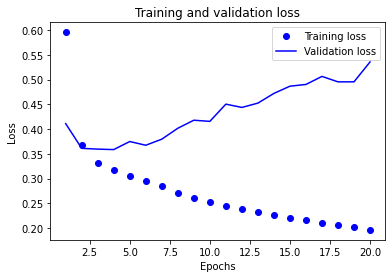

In [17]:
history_dict = history.history


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

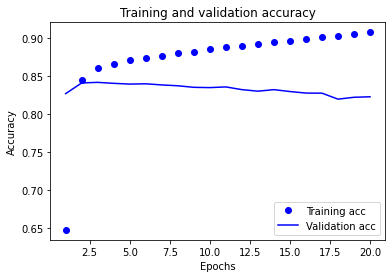

In [18]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

epoch 이 5를 넘어서는 순간부터 검증 데이터의 loss 는 전체적을 올라고 train 데이터의 loss 만 줄어들고 있다.  
다시 말해 학습된 모델이 train 데이터에 과적합 되었음을 추측할 수 있다.

### 2-3-2. CNN  
생성

In [25]:
# CNN 방식 ConvD 만 사용한다.

vocab_size = 9996  # 어휘 사전의 크기입니다
word_vector_dim = 20 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 20)          199920    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1616      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

결과

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
203/203 [==============================] - 3s 6ms/step - loss: 0.5382 - accuracy: 0.7217 - val_loss: 0.3769 - val_accuracy: 0.8347
Epoch 2/20
203/203 [==============================] - 1s 5ms/step - loss: 0.3497 - accuracy: 0.8493 - val_loss: 0.3568 - val_accuracy: 0.8423
Epoch 3/20
203/203 [==============================] - 1s 5ms/step - loss: 0.3130 - accuracy: 0.8690 - val_loss: 0.3548 - val_accuracy: 0.8451
Epoch 4/20
203/203 [==============================] - 1s 5ms/step - loss: 0.2876 - accuracy: 0.8822 - val_loss: 0.3584 - val_accuracy: 0.8442
Epoch 5/20
203/203 [==============================] - 1s 5ms/step - loss: 0.2601 - accuracy: 0.8965 - val_loss: 0.3693 - val_accuracy: 0.8437
Epoch 6/20
203/203 [==============================] - 1s 5ms/step - loss: 0.2297 - accuracy: 0.9115 - val_loss: 0.3955 - val_accuracy: 0.8407
Epoch 7/20
203/203 [==============================] - 1s 5ms/step - loss: 0.1978 - accuracy: 0.9264 - val_loss: 0.4165 - val_accuracy: 0.8392
Epoch 

평가 및 시각화

In [28]:
results = model.evaluate(test_inputs,  y_test, verbose=2)


1514/1514 - 2s - loss: 1.0904 - accuracy: 0.8054


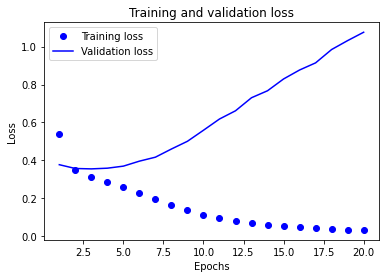

In [29]:
history_dict = history.history


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

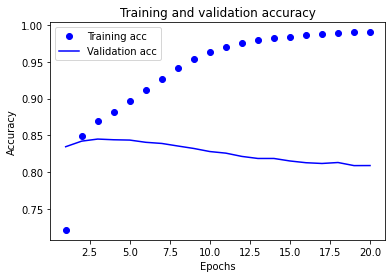

In [30]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

마찬가지로 과적합이 일어나고 있다.

### 2-3-3. CNN - maxpooling  
모델 생성

In [18]:
# global maxpooling 을 사용한다.

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          199920    
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 200,097
Trainable params: 200,097
Non-trainable params: 0
_________________________________________________________________


결과

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
203/203 [==============================] - 1s 4ms/step - loss: 0.6201 - accuracy: 0.6697 - val_loss: 0.4874 - val_accuracy: 0.8056
Epoch 2/20
203/203 [==============================] - 1s 4ms/step - loss: 0.4094 - accuracy: 0.8299 - val_loss: 0.3776 - val_accuracy: 0.8332
Epoch 3/20
203/203 [==============================] - 1s 4ms/step - loss: 0.3398 - accuracy: 0.8569 - val_loss: 0.3628 - val_accuracy: 0.8387
Epoch 4/20
203/203 [==============================] - 1s 4ms/step - loss: 0.3088 - accuracy: 0.8715 - val_loss: 0.3624 - val_accuracy: 0.8395
Epoch 5/20
203/203 [==============================] - 1s 4ms/step - loss: 0.2868 - accuracy: 0.8817 - val_loss: 0.3675 - val_accuracy: 0.8400
Epoch 6/20
203/203 [==============================] - 1s 4ms/step - loss: 0.2686 - accuracy: 0.8908 - val_loss: 0.3754 - val_accuracy: 0.8390
Epoch 7/20
203/203 [==============================] - 1s 4ms/step - loss: 0.2529 - accuracy: 0.8988 - val_loss: 0.3848 - val_accuracy: 0.8382
Epoch 

평가 및 시각화

In [33]:
results = model.evaluate(test_inputs,  y_test, verbose=2)


1514/1514 - 2s - loss: 0.5972 - accuracy: 0.8128


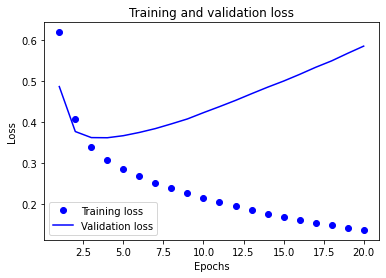

In [34]:
history_dict = history.history


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

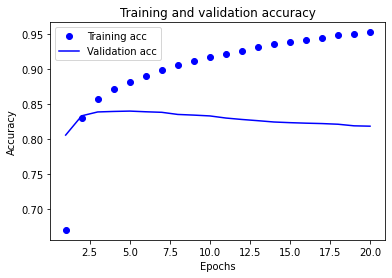

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

마찬가지로 과적합이 일어난다.

---

각 모델들의 accuracy 를 종합해 보면

RNN                   : 0.8293  
CNN 1-D               : 0.8054  
CNN globalmaxplooing  : 0.8169    

으로, 그나마 RNN 에서 82%로 가장 좋은 성능을 보인다.


---

## 2-4. Pre-trained Embedding data (Ko)

상단의 모델에서는 우리가 만든 9996개의 단어를 가지고 임시 임베딩을 했다.  
해당 단어사전으로 만든 임베딩의 단어 유사도를 알아보기로 한다.

### 2-4-1. 우리의 단어사전 분석

In [20]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(9996, 20)


현재 각 단어가 20개의 벡터값으로 표현되어 있다.

In [37]:

word2vec_file_path = os.getenv('HOME')+'/aiffel/workplace/[E-06]/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['ㅋㅋㅋ']
vector

array([-0.33015117, -0.01338573, -0.30968502,  0.03285117,  0.00497736,
       -0.15218377, -0.04306409, -0.1516609 , -0.09199471, -0.02431269,
       -0.09632351, -0.2314864 , -0.05165323, -0.01680278, -0.05301832,
       -0.24944375, -0.24970013, -0.25418597, -0.23021825, -0.07592441],
      dtype=float32)

우리의 단어사전을 파일로 저장하여, 특정 단어와 관련도가 높은 유사단어를 뽑아 보았다.

In [39]:
word_vectors.similar_by_word("사랑")

[('흥미', 0.870549201965332),
 ('즐겁', 0.8093381524085999),
 ('돋', 0.8091644048690796),
 ('기회', 0.8013196587562561),
 ('이번', 0.8010327816009521),
 ('찡', 0.7919623851776123),
 ('때', 0.7743175029754639),
 ('터미네이터', 0.773722231388092),
 ('올리비아', 0.7726334929466248),
 ('선생', 0.7702509760856628)]

진짜 완전 형편이 없다.

In [40]:
word_vectors.similar_by_word("우정")

[('귀여움', 0.8642995357513428),
 ('이스트우드', 0.8636992573738098),
 ('순수', 0.8622899651527405),
 ('회장', 0.8610565066337585),
 ('향해', 0.8608404397964478),
 ('갑', 0.8426898717880249),
 ('씀', 0.841067373752594),
 ('임다', 0.8383880853652954),
 ('고아라', 0.8366931080818176),
 ('꿀', 0.8322663903236389)]

우정은 귀여울 수 있지만 고아라씨와는 무슨 관계일까..?

다음과 같이 적은 데이터 양으로는 훌륭하지 못한 유사도를 가지고 있다.  
때문에 git에서 제공되는 Korea 단어사전을 가져와 사용해보도록 한다.



---

### 2-4-2. pre-trained 임베딩 써보기

자료는 이곳에 준비되어 있다.  
[규병 님의 깃허브](https://github.com/Kyubyong/wordvectors)


In [2]:
word2vec_path = os.getenv('HOME')+'/aiffel/workplace/[E-06]/data/ko.bin'
ko_model = Word2Vec.load(word2vec_path)

In [3]:
ko_model.similar_by_word("사랑")

/tmp/ipykernel_335/1747209064.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko_model.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [89]:
ko_model.similar_by_word("노래")

/tmp/ipykernel_1457/3419879231.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko_model.similar_by_word("노래")


[('가사', 0.7066930532455444),
 ('곡조', 0.6870777010917664),
 ('곡', 0.6749094724655151),
 ('발라드', 0.6573207378387451),
 ('멜로디', 0.6572505235671997),
 ('주제가', 0.6365448832511902),
 ('애국가', 0.6258596181869507),
 ('곡인', 0.6254721879959106),
 ('히트곡', 0.6253563165664673),
 ('원곡', 0.6200122833251953)]

우리의 형편없는 유사도와 달리  
이곳에서는 충분히 관련 있는 단어들이 유의미하게 나오고 있다.

In [90]:
ko_model.wv.vectors.shape

(30185, 200)

해당 모델은 30185개의 단어가 많이 쓰이는 순서대로 200 개의 벡터값으로 표현된다.  
우리는 상위에 가장 많이 쓰이는 10000개를 불러 와 모델학습을 시켜보도록 한다.

In [16]:
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)


for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/tmp/ipykernel_335/1009935147.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
/tmp/ipykernel_335/1009935147.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


In [17]:
embedding_matrix.shape

(10000, 200)

RNN 모델을 사용하여 Pre-trained Embedding data 를 가져와 넣었다.

In [18]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # pre-trained data
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(512))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1460224   
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1464/1464 [==============================] - 22s 13ms/step - loss: 0.4594 - accuracy: 0.7610 - val_loss: 0.3434 - val_accuracy: 0.8480
Epoch 2/5
1464/1464 [==============================] - 19s 13ms/step - loss: 0.3055 - accuracy: 0.8680 - val_loss: 0.3233 - val_accuracy: 0.8594
Epoch 3/5
1464/1464 [==============================] - 19s 13ms/step - loss: 0.2489 - accuracy: 0.8968 - val_loss: 0.3337 - val_accuracy: 0.8599
Epoch 4/5
1464/1464 [==============================] - 19s 13ms/step - loss: 0.1911 - accuracy: 0.9239 - val_loss: 0.3579 - val_accuracy: 0.8555
Epoch 5/5
1464/1464 [==============================] - 20s 13ms/step - loss: 0.1361 - accuracy: 0.9483 - val_loss: 0.4342 - val_accuracy: 0.8529


### 임베딩을 거친 결과값은????

In [20]:
results = model.evaluate(test_inputs,  y_test, verbose=2)


1514/1514 - 5s - loss: 0.4414 - accuracy: 0.8508


0.85%로 우리가 학습시켰던 어떤 모델보다도 높은 유의미한 결과가 나왔다.

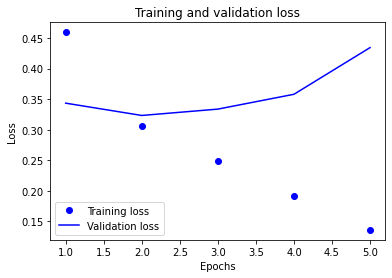

In [21]:
history_dict = history.history


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

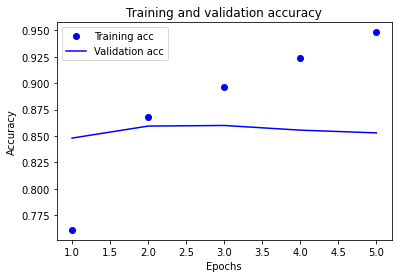

In [22]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3. POTG

### 3-1. 소감

#### " 🙄음,, 글치글치,, 아 잠깐만,,? 어..? "
" 분명 무슨 말인지 알겠는데 되돌아보면 다시 혼란스러워지는 전처리-임베딩-훈련 작업이었습니다.  
아무래도 그 과정이 길고 복잡하다보니 끊어서 공부하면 안되겠다는 생각이 들었습니다.  
공부할 때 한번에 쭉 나가야 논리적으로 훨씬 와닿으실 것 같네요! "

### 3-2. 어려웠던 점과 극복방안

- 한국어 특화 분석을 위한 Mecab 라이브러리 사용
지금까지 배운 NLP 와는 달리, 이번 과제는 한국어를 분석하는 프로젝트였다. 그래서 영어분석 때는 쓰지 않았던 Mecab 라이브러리를 사용했으나, 이것이 무엇인지 이해하기가 쉽지 않았다. 

한국어는 영어와 다른 문장구조와 문법을 가지고 있는데, Mecab은 그러한
형태소를 분석하여 튜플 형태로 제공해준다.


<img src="./img/mecab.PNG"></img>


관련 테이블을 이곳에서 찾아 쉽게 이해할 수 있었다.

[Mecab 형태소 태깅 설명](https://sens.tistory.com/445)

<img src="./img/mecab2.PNG"></img>

- 영어 / 한국어 임베딩 시 고려해야 할 사항 (gensim 버전,다른 임베딩 로드 메서드)

한국어는 영어 임베딩 메서드와 다른 메서드를 사용해야 한다.

KeyedVectors.load_word2vec_format - 영어
Word2Vec.load(word2vec_path) - 한국어 

- gensim 사용시 버전을 3.x.x 로 맞추라 하셨는데,
  나의 경우에는 3.4.0도 되지 않았고 3.8.1 하나의 버전만 되었다,
  또 새로 설치한 후에는 해당 파일을 완전히 shut douwn 한 다음 켜야 제대로 된 구동이 되었다.
  <img url="./error.PNG"></img>